In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/soumadityadas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/soumadityadas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [31]:
df = pd.read_csv('spam.csv', encoding='latin1')  # latin1 is used as a good fallback encoding
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [32]:
# Check Data Shape
df.shape

(5572, 5)

In [33]:
# Check Null Values
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [34]:
# Read the CSV file with appropriate encoding
df = pd.read_csv('spam.csv', encoding='latin1')

# Drop columns that start with 'Unnamed:'
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Alternative method:
# df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col])

# Display the result
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [35]:
# Find Duplicate
df.duplicated().any()

np.True_

In [36]:
# drop Duplicates
df.drop_duplicates(inplace=True)

In [37]:
df.duplicated().any()

np.False_

In [38]:
# Read the CSV file with appropriate encoding
df = pd.read_csv('spam.csv', encoding='latin1')

# Drop unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Rename the columns 'v1' to 'Category' and 'v2' to 'Message'
df = df.rename(columns={'v1': 'Category', 'v2': 'Message'})

# Display the result
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


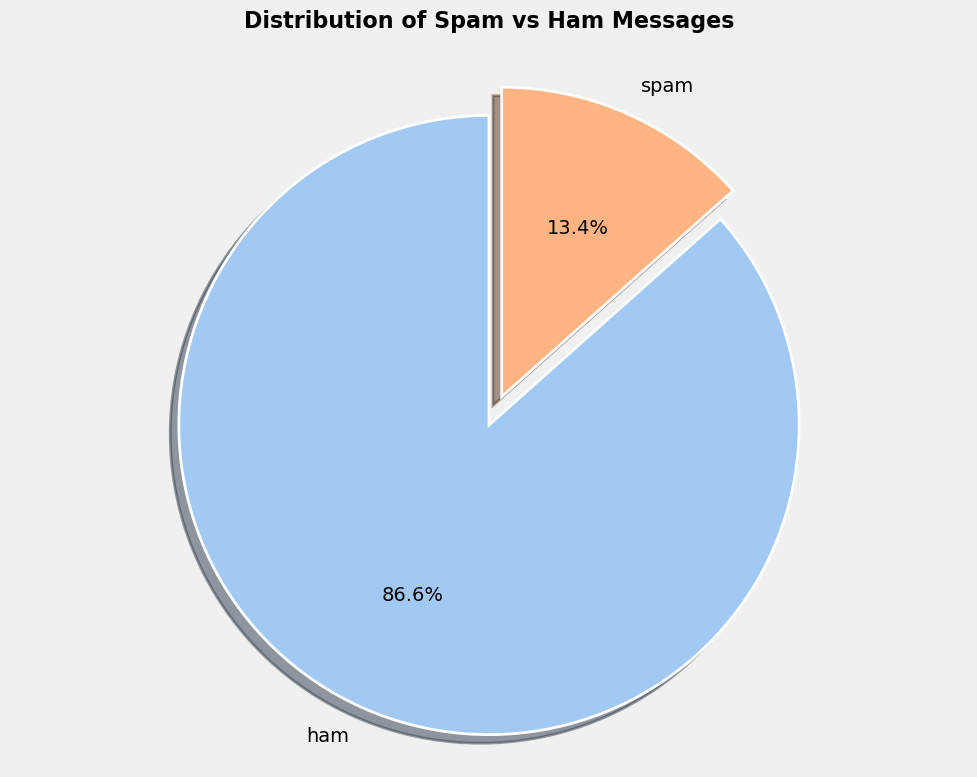

In [40]:
# Set the style for a more modern look
plt.style.use('fivethirtyeight')

# Count the categories
category_counts = df['Category'].value_counts()

# Create a figure with a specific size
plt.figure(figsize=(10, 8))

# Create a pie chart with enhanced styling
explode = [0.1, 0]  # Explode the first slice (usually the smaller one for emphasis)
colors = sns.color_palette('pastel')  # Use a nice color palette

# Create the pie chart with more styling options
plt.pie(
    category_counts, 
    labels=category_counts.index, 
    autopct='%1.1f%%',  # Show percentages with 1 decimal place
    startangle=90,      # Start angle for the pie
    shadow=True,        # Add shadow
    explode=explode,    # Explode slices
    colors=colors,      # Custom colors
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}  # Add white edges between slices
)

# Add a title with custom styling
plt.title('Distribution of Spam vs Ham Messages', fontsize=16, fontweight='bold', pad=20)

# Add a circle at the center to make it look like a donut chart (optional)
# centre_circle = plt.Circle((0,0), 0.60, fc='white')
# plt.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

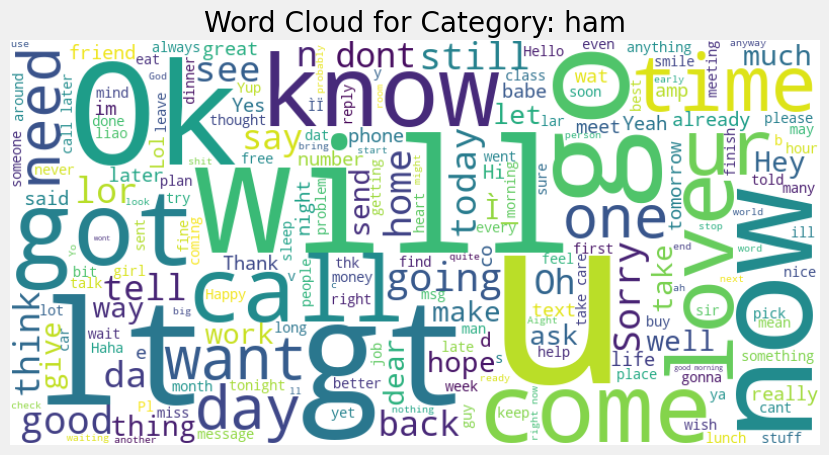

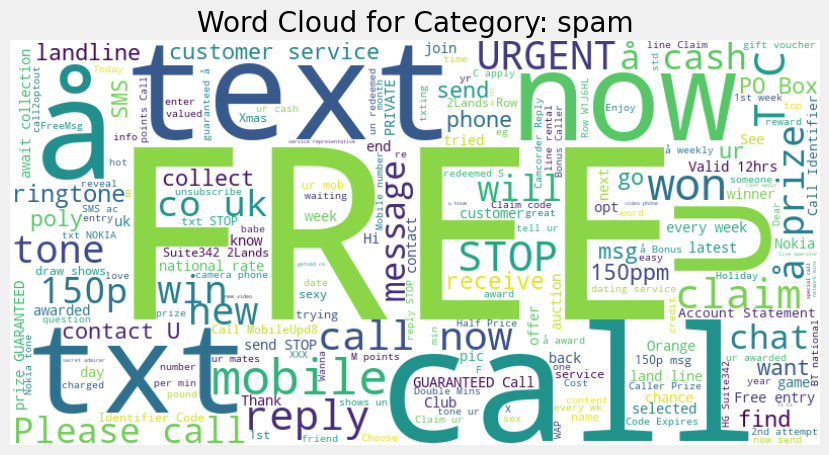

In [41]:
# Iterate through unique categories
for category in df['Category'].unique():
    # Filter the DataFrame for the current category
    filtered_df = df[df['Category'] == category]
    
    # Concatenate all text data for the current category
    text = ' '.join(filtered_df['Message'])
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category: {category}')
    plt.axis('off')
    plt.show()

In [42]:
# Encode Category column 
le = LabelEncoder()
df['Category']=le.fit_transform(df['Category'])
df.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [45]:
# Convert 'Text' column to lowercase
df['Message'] = df['Message'].str.lower()
# Remove extra white spaces from the 'Text' column
df['Message'] = df['Message'].str.strip()
df.head()

,Category,Message
0,0,"go until jurong point, crazy.. available only ..."
1,0,ok lar... joking wif u oni...
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor... u c already then say...
4,0,"nah i don't think he goes to usf, he lives aro..."


In [47]:
# Function to remove HTML tags from text
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Remove HTML tags from 'Text' column
df['Message'] = df['Message'].apply(remove_html_tags)
df.head()

,Category,Message
0,0,"go until jurong point, crazy.. available only ..."
1,0,ok lar... joking wif u oni...
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor... u c already then say...
4,0,"nah i don't think he goes to usf, he lives aro..."


In [50]:
# Define a function to remove URLs using regular expressions
def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

# Apply the function to the 'Text' column
df['Message'] = df['Message'].apply(remove_urls)
df.head()

,Category,Message
0,0,"go until jurong point, crazy.. available only ..."
1,0,ok lar... joking wif u oni...
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor... u c already then say...
4,0,"nah i don't think he goes to usf, he lives aro..."


In [51]:
string.punctuation

# Define the punctuation characters to remove
punctuation = string.punctuation

In [52]:
# Function to remove punctuation from text
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation))

# Apply remove_punctuation function to 'Text' column
df['Message'] = df['Message'].apply(remove_punctuation)

In [53]:
df.head()

,Category,Message
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor u c already then say
4,0,nah i dont think he goes to usf he lives aroun...


In [54]:
def remove_special_characters(text):
    # Define the pattern to match special characters
    pattern = r'[^a-zA-Z0-9\s]'  # Matches any character that is not alphanumeric or whitespace
    
    # Replace special characters with an empty string
    clean_text = re.sub(pattern, '', text)
    
    return clean_text

# Apply the function to the 'Message' column
df['Message'] = df['Message'].apply(remove_special_characters)

In [55]:
# Function to remove numeric values from text
def remove_numeric(text):
    return re.sub(r'\d+', '', text)

# Apply the function to the "Message" column
df['Message'] = df['Message'].apply(remove_numeric)

In [56]:
df.head()

,Category,Message
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in a wkly comp to win fa cup final...
3,0,u dun say so early hor u c already then say
4,0,nah i dont think he goes to usf he lives aroun...


In [57]:
# Define a function to remove non-alphanumeric characters
def remove_non_alphanumeric(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Apply the function to the "Message" column
df['Message'] = df['Message'].apply(remove_non_alphanumeric)

In [58]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [59]:
# Function to replace chat words with their full forms
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

# Apply replace_chat_words function to 'Text' column
df['Message'] = df['Message'].apply(replace_chat_words)

In [60]:
# Download NLTK stopwords corpus
nltk.download('stopwords')

# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Function to remove stop words from text
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply remove_stopwords function to 'Text' column
df['Message'] = df['Message'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/soumadityadas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
# Function to remove emojis from text
def remove_emojis(text):
    return emoji.demojize(text)

# Apply remove_emojis function to 'Text' column
df['Message'] = df['Message'].apply(remove_emojis)

In [62]:
# Initialize the Porter Stemmer
porter_stemmer = PorterStemmer()

# Apply stemming
df['Message_stemmed'] = df['Message'].apply(lambda x: ' '.join([porter_stemmer.stem(word) for word in x.split()]))

In [63]:
# Intlize CountVectorizer
cv = CountVectorizer()

# Fitting CountVectorizer on X 
X = cv.fit_transform(df['Message_stemmed']).toarray()
y = df['Category']

In [64]:
# Train Test Split 
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [65]:
# Logistic Regression with tuned parameters
lr_model = LogisticRegression(C=0.1, solver='liblinear', max_iter=500)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Multinomial Naive Bayes with tuned parameters
mnb_model = MultinomialNB(alpha=0.1)
mnb_model.fit(X_train, y_train)
mnb_pred = mnb_model.predict(X_test)

# Gaussian Naive Bayes
gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)
gnb_pred = gnb_model.predict(X_test)

# Support Vector Machines (SVM) with tuned parameters
svm_model = SVC(C=10.0, kernel='rbf', gamma='auto')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

# Decision Trees with tuned parameters
dt_model = DecisionTreeClassifier(max_depth=10, min_samples_split=5)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

# Random Forests with tuned parameters
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=10)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Gradient Boosting Classifier with tuned parameters
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=5)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

# XGBoost Classifier with tuned parameters
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)


In [66]:
# Calculate accuracy, precision and recall for each model
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred, average='weighted')
lr_recall = recall_score(y_test, lr_pred, average='weighted')
lr_conf_matrix = confusion_matrix(y_test, lr_pred)

mnb_accuracy = accuracy_score(y_test, mnb_pred)
mnb_precision = precision_score(y_test, mnb_pred, average='weighted')
mnb_recall = recall_score(y_test, mnb_pred, average='weighted')
mnb_conf_matrix = confusion_matrix(y_test, mnb_pred)

gnb_accuracy = accuracy_score(y_test, gnb_pred)
gnb_precision = precision_score(y_test, gnb_pred, average='weighted')
gnb_recall = recall_score(y_test, gnb_pred, average='weighted')
gnb_conf_matrix = confusion_matrix(y_test, gnb_pred)

svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred, average='weighted')
svm_recall = recall_score(y_test, svm_pred, average='weighted')
svm_conf_matrix = confusion_matrix(y_test, svm_pred)

dt_accuracy = accuracy_score(y_test, dt_pred)
dt_precision = precision_score(y_test, dt_pred, average='weighted')
dt_recall = recall_score(y_test, dt_pred, average='weighted')
dt_conf_matrix = confusion_matrix(y_test, dt_pred)

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred, average='weighted')
rf_recall = recall_score(y_test, rf_pred, average='weighted')
rf_conf_matrix = confusion_matrix(y_test, rf_pred)

gb_accuracy = accuracy_score(y_test, gb_pred)
gb_precision = precision_score(y_test, gb_pred, average='weighted')
gb_recall = recall_score(y_test, gb_pred, average='weighted')
gb_conf_matrix = confusion_matrix(y_test, gb_pred)

xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred, average='weighted')
xgb_recall = recall_score(y_test, xgb_pred, average='weighted')
xgb_conf_matrix = confusion_matrix(y_test, xgb_pred)

In [68]:
# Print precision, recall, and accuracy for each model
print("Logistic Regression:")
print(f"The accuracy score of Logistic Regression is {lr_accuracy}, The Precision Score is {lr_precision},The Recall Score is {lr_recall}")
print(f"The Confusion matrix is \n{lr_conf_matrix}")
print("\n")

print("Multinomial Naive Bayes:")
print(f"The accuracy score of MultinomialNB is {mnb_accuracy}, The Precision Score is {mnb_precision},The Recall Score is {mnb_recall}")
print(f"The Confusion matrix is \n{mnb_conf_matrix}")
print("\n")

print("Gaussian Naive Bayes:")
print(f"The accuracy score of GaussianNB is {gnb_accuracy}, The Precision Score is {gnb_precision},The Recall Score is {gnb_recall}")
print(f"The Confusion matrix is \n{gnb_conf_matrix}")
print("\n")

print("SVM:")
print(f"The accuracy score of SVC is {svm_accuracy}, The Precision Score is {svm_precision},The Recall Score is {svm_recall}")
print(f"The Confusion matrix is \n{svm_conf_matrix}")
print("\n")

print("Decision Trees:")
print(f"The accuracy score of Decision Tree classifier is {dt_accuracy}, The Precision Score is {dt_precision},The Recall Score is {dt_recall}")
print(f"The Confusion matrix is \n{dt_conf_matrix}")
print("\n")

print("Random Forests:")
print(f"The accuracy score of Random Forest classifier is {rf_accuracy}, The Precision Score is {rf_precision},The Recall Score is {rf_recall}")
print(f"The Confusion matrix is \n{rf_conf_matrix}")
print("\n")

print("Gradient Boosting Classifier:")
print(f"The accuracy score of Gradient Boosting Classifier is {gb_accuracy}, The Precision Score is {gb_precision},The Recall Score is {gb_recall}")
print(f"The Confusion matrix is \n{gb_conf_matrix}")
print("\n")

print("XGBoost Classifier:")
print(f"The accuracy score of XGBoost Classifier is {xgb_accuracy}, The Precision Score is {xgb_precision},The Recall Score is {xgb_recall}")
print(f"The Confusion matrix is \n{xgb_conf_matrix}")
print("\n")


Logistic Regression:
The accuracy score of Logistic Regression is 0.9659192825112107, The Precision Score is 0.9672104761947341,The Recall Score is 0.9659192825112107
The Confusion matrix is 
[[965   0]
 [ 38 112]]


Multinomial Naive Bayes:
The accuracy score of MultinomialNB is 0.9695067264573991, The Precision Score is 0.9712121677383754,The Recall Score is 0.9695067264573991
The Confusion matrix is 
[[941  24]
 [ 10 140]]


Gaussian Naive Bayes:
The accuracy score of GaussianNB is 0.8582959641255605, The Precision Score is 0.9132768422821261,The Recall Score is 0.8582959641255605
The Confusion matrix is 
[[824 141]
 [ 17 133]]


SVM:
The accuracy score of SVC is 0.9094170403587444, The Precision Score is 0.917999478373535,The Recall Score is 0.9094170403587444
The Confusion matrix is 
[[965   0]
 [101  49]]


Decision Trees:
The accuracy score of Decision Tree classifier is 0.9479820627802691, The Precision Score is 0.9481241356431285,The Recall Score is 0.9479820627802691
The Conf

In [69]:
# Create a dictionary with evaluation results
evaluation_data = {
    'Model': ['Logistic Regression', 'MultinomialNB', 'GaussianNB', 'Decision Tree', 'SVM', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Accuracy': [lr_accuracy, mnb_accuracy, gnb_accuracy, dt_accuracy, svm_accuracy, rf_accuracy, gb_accuracy, xgb_accuracy],
    'Precision': [lr_precision, mnb_precision, gnb_precision, dt_precision, svm_precision, rf_precision, gb_precision, xgb_precision],
   }

# Create a DataFrame
evaluation_df = pd.DataFrame(evaluation_data)

# Sort the DataFrame based on Accuracy and Precision columns in descending order
evaluation_df = evaluation_df.sort_values(by=['Accuracy', 'Precision'], ascending=False)

# Display the sorted DataFrame
print(evaluation_df)

                 Model  Accuracy  Precision
1        MultinomialNB  0.969507   0.971212
7              XGBoost  0.967713   0.968205
0  Logistic Regression  0.965919   0.967210
6    Gradient Boosting  0.962332   0.963082
3        Decision Tree  0.947982   0.948124
5        Random Forest  0.914798   0.922434
4                  SVM  0.909417   0.917999
2           GaussianNB  0.858296   0.913277


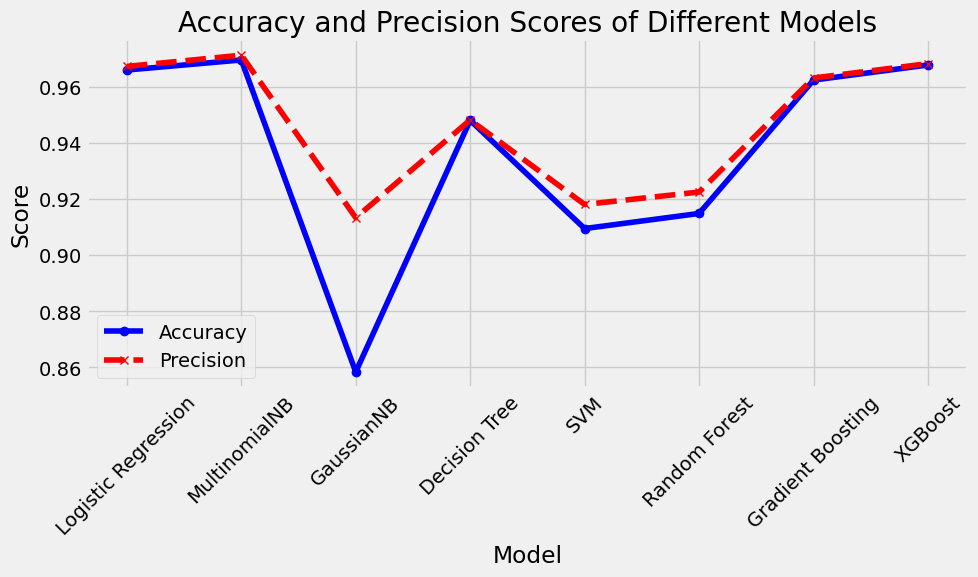

In [70]:
# Define the models and their corresponding accuracy and precision scores
Models = ['Logistic Regression', 'MultinomialNB', 'GaussianNB', 'Decision Tree', 'SVM', 'Random Forest', 'Gradient Boosting', 'XGBoost']
Accuracy = [lr_accuracy, mnb_accuracy, gnb_accuracy, dt_accuracy, svm_accuracy, rf_accuracy, gb_accuracy, xgb_accuracy]
Precision = [lr_precision, mnb_precision, gnb_precision, dt_precision, svm_precision, rf_precision, gb_precision, xgb_precision]

# Plotting
plt.figure(figsize=(10, 6))

# Plot accuracy scores
plt.plot(Models, Accuracy, marker='o', linestyle='-', color='b', label='Accuracy')

# Plot precision scores
plt.plot(Models, Precision, marker='x', linestyle='--', color='r', label='Precision')

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Accuracy and Precision Scores of Different Models')
plt.xticks(rotation=45)
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

Best model by Accuracy:
           Model  Accuracy  Precision  F1_approx
1  MultinomialNB  0.969507   0.971212   0.970359

Best model by Precision:
           Model  Accuracy  Precision  F1_approx
1  MultinomialNB  0.969507   0.971212   0.970359

Best model by F1 (approximated):
           Model  Accuracy  Precision  F1_approx
1  MultinomialNB  0.969507   0.971212   0.970359


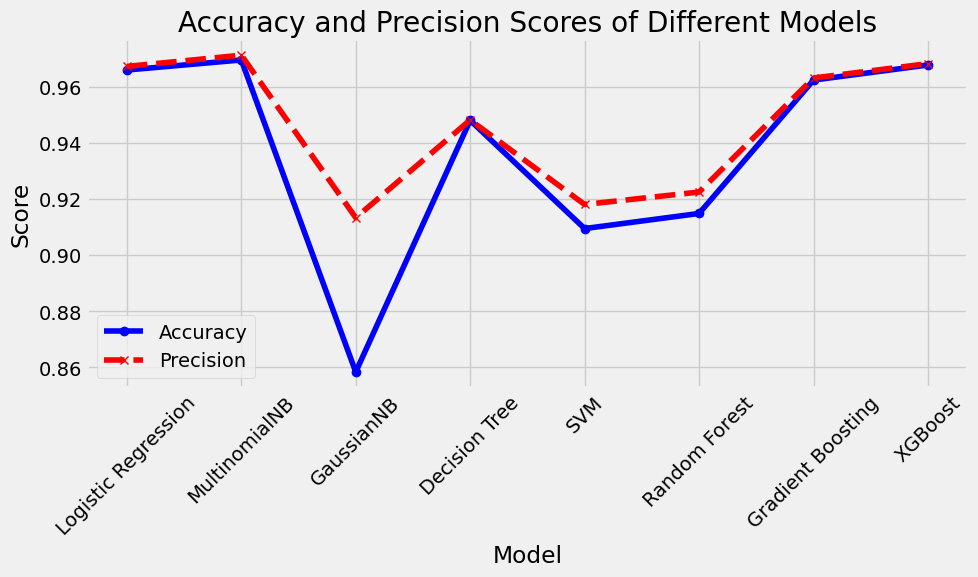


Recommended best model based on accuracy: MultinomialNB
Accuracy: 0.9695, Precision: 0.9712


In [74]:
# Define the models and their corresponding accuracy and precision scores
Models = ['Logistic Regression', 'MultinomialNB', 'GaussianNB', 'Decision Tree', 'SVM', 'Random Forest', 'Gradient Boosting', 'XGBoost']
Accuracy = [lr_accuracy, mnb_accuracy, gnb_accuracy, dt_accuracy, svm_accuracy, rf_accuracy, gb_accuracy, xgb_accuracy]
Precision = [lr_precision, mnb_precision, gnb_precision, dt_precision, svm_precision, rf_precision, gb_precision, xgb_precision]

# Create a DataFrame to easily compare metrics
import pandas as pd
results_df = pd.DataFrame({
    'Model': Models,
    'Accuracy': Accuracy,
    'Precision': Precision
})

# Calculate F1 score (harmonic mean of precision and recall)
# If you have recall values, you could use them directly
# Otherwise, this is a simplified approach assuming balanced classes
results_df['F1_approx'] = 2 * (results_df['Precision'] * results_df['Accuracy']) / (results_df['Precision'] + results_df['Accuracy'])

# Sort by different metrics to find the best model
print("Best model by Accuracy:")
print(results_df.sort_values('Accuracy', ascending=False).head(1))

print("\nBest model by Precision:")
print(results_df.sort_values('Precision', ascending=False).head(1))

print("\nBest model by F1 (approximated):")
print(results_df.sort_values('F1_approx', ascending=False).head(1))

# Plot the original comparison
plt.figure(figsize=(10, 6))
plt.plot(Models, Accuracy, marker='o', linestyle='-', color='b', label='Accuracy')
plt.plot(Models, Precision, marker='x', linestyle='--', color='r', label='Precision')
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Accuracy and Precision Scores of Different Models')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Highlight the best overall model (you can change the criterion)
best_model_index = results_df['Accuracy'].idxmax()  # Change to 'Precision' or 'F1_approx' if preferred
best_model = results_df.iloc[best_model_index]

print(f"\nRecommended best model based on accuracy: {best_model['Model']}")
print(f"Accuracy: {best_model['Accuracy']:.4f}, Precision: {best_model['Precision']:.4f}")

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import numpy as np

# First, we need to train the TF-IDF vectorizer and classifier
# This is a simplified example - in a real scenario, you would train on a larger dataset

# Sample data
emails = [
    "Free money opportunity", 
    "Meeting tomorrow at 10am",
    "Win a free iPhone now",
    "Project deadline reminder"
]
labels = [1, 0, 1, 0]  # 1 for spam, 0 for ham

# Create and train the TF-IDF vectorizer
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(emails)

# Train the Multinomial Naive Bayes classifier
mnb_classifier = MultinomialNB()
mnb_classifier.fit(X_train, labels)

def predict_email(email):
    # Convert email into numerical vector using the trained TF-IDF vectorizer
    email_vector = tfidf.transform([email])
    
    # Convert sparse matrix to dense array
    email_vector_dense = email_vector.toarray()
    
    # Use the trained SVM model to make predictions
    prediction = mnb_classifier.predict(email_vector_dense)
    
    # Print the prediction
    if prediction[0] == 1:
        print("The email is predicted as spam.")
    else:
        print("The email is predicted as ham.")

# Get user input for email
user_email = input("Enter the email text: ")

# Predict whether the input email is spam or ham
predict_email(user_email)


Enter the email text:  Subject: Download this App to Win Cash Prizes Daily 💰  Hi,  Install our new app and start winning instant rewards up to ₹10,000 every day!  Download now: http://dailyprizeapp.in/fakeapk  Start earning today!


The email is predicted as spam.
